In [ ]:
root_path = "/soe/vigneshs/projects/nlp_243/project_1/data/"

In [1]:
# !pip install transformers
# !pip install evaluate
# !pip install scikit-learn

In [2]:
import numpy as np
import pandas as pd

from datasets import load_dataset
from datasets import ClassLabel, Value

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import AdamW

from transformers import BertTokenizer, BertModel
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import get_scheduler

import evaluate

from sklearn.metrics import f1_score, precision_score, recall_score, classification_report

# from tqdm.auto import tqdm
from tqdm.notebook import tqdm_notebook
import json
from itertools import chain

import matplotlib.pyplot as plt
import seaborn as sns

/soe/vigneshs/miniconda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# select device
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
device

device(type='cuda', index=3)

In [ ]:
train_file_path = root_path+'train.jsonl'
val_file_path = root_path+'validation.jsonl'

train_classification_data_bert_file_path = root_path+'train_classification_data_bert.jsonl'
undersampled_train_classification_data_bert_file_path = root_path+'undersampled_train_classification_data_bert.jsonl'
val_classification_data_bert_file_path = root_path+'val_classification_data_bert.jsonl'

model_path = root_path+'bert_undersampled_model.pth'

train_qa_data_all_file_path = root_path+'qa/train_qa_data_all.json'
val_qa_data_all_file_path = root_path+'qa/val_qa_data_all.json'
val_qa_data_oracle_file_path = root_path+'qa/val_qa_data_oracle.json'

val_qa_data_bert_top_4_file_path = root_path+'qa/val_qa_data_bert_top_4.json'
val_qa_data_bert_top_10_file_path = root_path+'qa/val_qa_data_bert_top_10.json'

In [5]:
# data preprocessing

def load_data(file_path):
  with open(file_path, 'r') as f:
    sentences = [json.loads(sentence.rstrip()) for sentence in f.readlines()]
    filtered_sentences = [{_key: _value for _key, _value in _sentence.items() if _key in ['uuid', 'postText', 'targetTitle', 'targetParagraphs', 'spoiler', 'spoilerPositions', 'tags']} for _sentence in sentences]
    return filtered_sentences

In [6]:
# load data

train_data = load_data(train_file_path)
val_data = load_data(val_file_path)

In [7]:
# reformat data and add proper spoiler positions using simple heuristics observed during data analysis

def reformat_spoiler_positions(data):
    reformatted_data = []
    ignore_idx = []

    for _idx, _sentence in enumerate(data):

        spoiler_positions = _sentence['spoilerPositions']
        target_title = _sentence['targetTitle']
        target_paragraphs = _sentence['targetParagraphs']
        all_target_paragraphs = [target_title] + target_paragraphs

        refactored_spoiler_positions = {}
        for _spoiler_passage_positions in spoiler_positions:
            if len(_spoiler_passage_positions) != 2:
                print('ignoring idx: {}'.format(_idx))
                ignore_idx.append(_idx)
                break

            _start_pos = _spoiler_passage_positions[0][1]
            _start_pos_passage = _spoiler_passage_positions[0][0]

            _end_pos = _spoiler_passage_positions[1][1]
            _end_pos_passage = _spoiler_passage_positions[1][0]

            if _start_pos_passage != _end_pos_passage:

                if _start_pos_passage == -1:
                    negative_mismatch_idx.append(_idx)

                _refactored_spoiler_positions = {}

                for _passage_idx in range(_start_pos_passage, _end_pos_passage):

                    if _passage_idx == _start_pos_passage:
                        _start = _start_pos - len(' '.join(target_paragraphs[:_passage_idx])) - 1
                        _refactored_spoiler_positions[_passage_idx + 1] = [
                            (_start if _start == 0 else _start - 1,
                             None)]

                    elif _passage_idx == _end_pos_passage:
                        _refactored_spoiler_positions[_passage_idx + 1] = [(None, _end_pos - 1 - len(' '.join(target_paragraphs[:_passage_idx])))]

                    else:
                        _refactored_spoiler_positions[_passage_idx + 1] = [(None, None)]

                for _key, _value in _refactored_spoiler_positions.items():
                    if _key not in refactored_spoiler_positions:
                        refactored_spoiler_positions[_key] = _value 
                    else:
                        refactored_spoiler_positions[_key].extend(_value)

            else:
                if _start_pos_passage + 1 not in refactored_spoiler_positions:
                    refactored_spoiler_positions[_start_pos_passage + 1] = [(_start_pos, _end_pos)]
                else:
                    refactored_spoiler_positions[_start_pos_passage + 1].append((_start_pos, _end_pos))

        reformatted_data.append({**_sentence, 'allTargetParagraphs': all_target_paragraphs, 'refactoredSpoilerPositions': refactored_spoiler_positions})
        
    return reformatted_data, ignore_idx


In [8]:
# reformat data with proper spoiler positions

train_data_reformatted, _ = reformat_spoiler_positions(data=train_data)
val_data_reformatted, _ = reformat_spoiler_positions(data=val_data)

ignoring idx: 546


In [9]:
# remove data datapoints where the spoiler positions don't match the actual spoiler text

def remove_bad_matches_data(data):

    exact_match_bad_annotations = []
    exact_match_bad_annotations_ids = []
    not_found_exact_matchs = {}

    clean_data = []

    for _idx, _sentence in enumerate(data):
        for _key in _sentence['refactoredSpoilerPositions'].keys():
            for _value_idx in range(len(_sentence['refactoredSpoilerPositions'][_key])):
        
                _start_pos = _sentence['refactoredSpoilerPositions'][_key][_value_idx][0]
                _end_pos = _sentence['refactoredSpoilerPositions'][_key][_value_idx][1]

                if _sentence['allTargetParagraphs'][_key][_start_pos: _end_pos] not in _sentence['spoiler'] and not any(True for _spoiler in _sentence['spoiler'] if _sentence['allTargetParagraphs'][_key][_start_pos: _end_pos] in _spoiler):
                    exact_match_bad_annotations.append(_sentence)
                    exact_match_bad_annotations_ids.append(_idx)
                    if _idx not in not_found_exact_matchs:
                        not_found_exact_matchs[_idx] = [_sentence['allTargetParagraphs'][_key][_start_pos: _end_pos]]
                    else:
                        not_found_exact_matchs[_idx].append(_sentence['allTargetParagraphs'][_key][_start_pos: _end_pos])
                else:
                    clean_data.append(_sentence)
  
    return clean_data, exact_match_bad_annotations_ids, not_found_exact_matchs



In [10]:
# clean data

clean_train_data, _, not_found_spoilers_train = remove_bad_matches_data(data=train_data_reformatted)
clean_val_data, _, not_found_spoilers_val = remove_bad_matches_data(data=val_data_reformatted)

In [13]:
# flatten nested data.
# change_multi true will relable the multi-spoiler data as either phrase or passage depending on
# the length of spoiler.

def flatten_data(data, change_multi=True):
    flattened_data = []
    for _sentence in data:

        uuid = _sentence['uuid']
        post = ' '.join(_sentence['postText'])
        target_title = _sentence['targetTitle']
        target_paragraphs = _sentence['allTargetParagraphs']
        spoiler_positions = _sentence['refactoredSpoilerPositions']
        spoiler_type = _sentence['tags']

        for _idx, _target_paragraph in enumerate(target_paragraphs):
            _spoiler_pos = spoiler_positions.get(_idx, None)

            if not change_multi and spoiler_type[0] != 'multi':
                _data = {
                    'uuid': uuid,
                    'targetParagraphId': _idx,
                    'postText': post,
                    'targetTitle': target_title,
                    'targetParagraph': _target_paragraph,
                    'spoilerType': spoiler_type[0] if _spoiler_pos else None,
                    'spoilerPos': _spoiler_pos if _spoiler_pos else None
                }
                flattened_data.append(_data)

            else:
                _spoiler_type = None
                if _spoiler_pos:
                    if spoiler_type[0] != 'multi':
                        _spoiler_type = spoiler_type[0]
                    else:
                        _spoiler_texts = ([_target_paragraph[__spoiler_pos[0]: __spoiler_pos[1]] for __spoiler_pos in _spoiler_pos])
                        _max_length = max([len(_x.split(' ')) for _x in _spoiler_texts])
                        if _max_length <=5:
                            _spoiler_type = 'phrase'
                        else:
                            _spoiler_type = 'passage'

                _data = {
                    'uuid': uuid,
                    'targetParagraphId': _idx,
                    'postText': post,
                    'targetTitle': target_title,
                    'targetParagraph': _target_paragraph,
                    'spoilerType': _spoiler_type,
                    'spoilerPos': _spoiler_pos if _spoiler_pos else None
                }
                flattened_data.append(_data)

    return flattened_data

In [14]:
# flattened data

flattened_train_data = flatten_data(data=clean_train_data, change_multi=True)
flattened_val_data = flatten_data(data=clean_val_data, change_multi=True)

<AxesSubplot:xlabel='Data', ylabel='Count'>

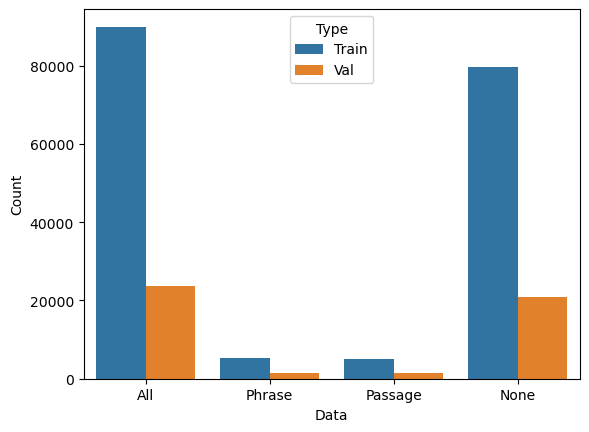

In [15]:
# flattened data distribution

distribution_df = pd.DataFrame(columns=["Data", "Type", "Count"], data={
    "Data":['All', 'All', 'Phrase', 'Phrase', 'Passage', 'Passage', 'None', 'None'],
    "Count": [len(flattened_train_data),
              len(flattened_val_data),
              len([_x for _x in flattened_train_data if _x['spoilerType'] == 'phrase']),
              len([_x for _x in flattened_val_data if _x['spoilerType'] == 'phrase']),
              len([_x for _x in flattened_train_data if _x['spoilerType'] == 'passage']),
              len([_x for _x in flattened_val_data if _x['spoilerType'] == 'passage']),
              len([_x for _x in flattened_train_data if _x['spoilerType'] == None]),
              len([_x for _x in flattened_val_data if _x['spoilerType'] == None])],
    "Type": ['Train', 'Val', 'Train', 'Val', 'Train', 'Val', 'Train', 'Val']
})
sns.barplot(distribution_df, x="Data" , y="Count", hue="Type")


In [16]:
# prepare classification data for bert

def prepare_classification_data_for_bert(flattened_data, undersample_ratio=1.0):
    clasification_data = []
    undersampled_data = []
    
    for _x in flattened_data:
        
        _label = 0        
        if _x['spoilerType'] == 'phrase':
            _label = 1
        elif _x['spoilerType'] == 'passage':
            _label = 2

        _data = {
            'uuid': _x['uuid'],
            'targetParagraphId': _x['targetParagraphId'],
            'text': _x['postText'] + ' ' + _x['targetParagraph'],
            'labels': _label,
            # **_x
          }
        clasification_data.append(_data)
    
    none_data = [_data for _data in clasification_data if _data['labels'] == 0]
    len_undersampled = int(len(none_data)*undersample_ratio)
    for _data in np.random.choice(none_data, size=len_undersampled, replace=False):
        undersampled_data.append(_data)
    for _x in clasification_data:
        if _x['labels'] in [1, 2]:
            undersampled_data.append(_x)
    
    return undersampled_data

In [17]:
# create data for bert

classification_train_data_bert = prepare_classification_data_for_bert(flattened_data=flattened_train_data)
undersampled_classification_train_data_bert = prepare_classification_data_for_bert(flattened_data=flattened_train_data, undersample_ratio=0.3)
classification_val_data_bert = prepare_classification_data_for_bert(flattened_data=flattened_val_data)


In [20]:
def write_classification_data(classification_data, out_file_path):
    with open(out_file_path, 'w') as outfile:
        for entry in classification_data:
            json.dump(entry, outfile)
            outfile.write('\n')


In [21]:
# write data bert

# write bert train classification data
write_classification_data(classification_data=classification_train_data_bert, out_file_path=train_classification_data_bert_file_path)

# write bert undersampled train classification data
write_classification_data(classification_data=undersampled_classification_train_data_bert, out_file_path=undersampled_train_classification_data_bert_file_path)

# write bert val classification data
write_classification_data(classification_data=classification_val_data_bert, out_file_path=val_classification_data_bert_file_path)


In [23]:
# load hf dataset
hf_dataset_train = load_dataset('json', data_files=undersampled_train_classification_data_file_path)
hf_dataset_val = load_dataset('json', data_files=val_classification_data_file_path)

Using custom data configuration default-ac501b15064844e1
Found cached dataset json (/soe/vigneshs/.cache/huggingface/datasets/json/default-ac501b15064844e1/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab)
100%|██████████| 1/1 [00:00<00:00, 210.93it/s]
Using custom data configuration default-965d2b8037158fb7
Found cached dataset json (/soe/vigneshs/.cache/huggingface/datasets/json/default-965d2b8037158fb7/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab)
100%|██████████| 1/1 [00:00<00:00, 274.19it/s]


In [24]:
# model type

model_type = "bert-base-uncased"


In [25]:
# load tokenizer

tokenizer = AutoTokenizer.from_pretrained(model_type)

In [26]:
# tokenize dataset

def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True)

tokenized_hf_dataset_train = hf_dataset_train.map(tokenize_function, batched=True)
tokenized_hf_dataset_val = hf_dataset_val.map(tokenize_function, batched=True)

Loading cached processed dataset at /soe/vigneshs/.cache/huggingface/datasets/json/default-ac501b15064844e1/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-a04d278ce51967ec.arrow
Loading cached processed dataset at /soe/vigneshs/.cache/huggingface/datasets/json/default-965d2b8037158fb7/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-1e2f97e6fb523e8e.arrow


In [27]:
# remove unnecessary text columns

tokenized_hf_dataset_train = tokenized_hf_dataset_train.remove_columns(["text"])
tokenized_hf_dataset_val = tokenized_hf_dataset_val.remove_columns(["text"])

In [28]:
# to torch format
tokenized_hf_dataset_train.set_format("torch")
tokenized_hf_dataset_val.set_format("torch")

In [29]:
# dataset

tokenized_hf_dataset_train, tokenized_hf_dataset_val

(DatasetDict({
     train: Dataset({
         features: ['uuid', 'targetParagraphId', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
         num_rows: 34252
     })
 }),
 DatasetDict({
     train: Dataset({
         features: ['uuid', 'targetParagraphId', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
         num_rows: 23790
     })
 }))

In [30]:
# small_train_dataset = tokenized_hf_dataset_train["train"].shuffle(seed=42).select(range(100))
# small_eval_dataset = tokenized_hf_dataset_val["train"].shuffle(seed=42).select(range(100))

# train_dataloader = DataLoader(small_train_dataset, shuffle=True, batch_size=8)
# eval_dataloader = DataLoader(small_eval_dataset, batch_size=8)

In [31]:
# dataloader

batch_size = 32
train_dataloader = DataLoader(tokenized_hf_dataset_train['train'], shuffle=True, batch_size=batch_size)
eval_dataloader = DataLoader(tokenized_hf_dataset_val['train'], batch_size=batch_size)


In [32]:
# load model

model = AutoModelForSequenceClassification.from_pretrained(model_type, num_labels=3)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [33]:
# load optimizer

optimizer = AdamW(model.parameters(), lr=5e-5)

In [34]:
# define scheduler

num_epochs = 6
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [35]:
# push model to device
model = model.to(device)

In [36]:
# clear any caches

torch.cuda.empty_cache()

In [38]:
# run training

train_loss_history = []
val_loss_history = []
phrase_f1 = []
passage_f1 = []
none_f1 = []
macro_f1 = []
max_macro_f1 = 0.

for epoch in range(num_epochs):

    train_running_loss_history = []
    val_running_loss_history = []
    running_loss = 0.
    batch_wise_labels = []
    batch_wise_predictions = []
    
    print('epoch: {}'.format(epoch))
    print('train')

    model.train()

    for _idx, batch in enumerate(train_dataloader):

        batch = {k: v.to(device) for k, v in batch.items() if k not in ['uuid', 'targetParagraphId']}

        outputs = model(**batch)
        
        loss = outputs.loss
        loss_value = loss.item()
        logits = outputs.logits

        running_loss += (loss_value - running_loss) / (_idx + 1)
        train_running_loss_history.append(running_loss)
        
        loss.backward()

        optimizer.step()
        lr_scheduler.step()

        optimizer.zero_grad()

        predictions = torch.argmax(logits, dim=-1)

        batch_wise_labels.append(batch['labels'].tolist())
        batch_wise_predictions.append(predictions.tolist())

    train_loss_history.append(np.mean(train_running_loss_history))
    all_labels = list(chain.from_iterable(batch_wise_labels))
    all_predictions = list(chain.from_iterable(batch_wise_predictions))
    
    print('Train Metrics')
    print(classification_report(all_labels, all_predictions, target_names=['none', 'phrase', 'passage']))

    running_loss = 0.
    batch_wise_uuids = []
    batch_wise_labels = []
    batch_wise_predictions = []
    batch_wise_logits = []

    print('eval')
    model.eval()

    for _idx, batch in enumerate(eval_dataloader):

        # batch_wise_uuids.append(batch['uuid'])
        # batch = {k: v.to(device) for k, v in batch.items() if k != 'uuid'}
        batch = {k: v.to(device) for k, v in batch.items() if k not in ['uuid', 'targetParagraphId']}

        with torch.no_grad():
            
            outputs = model(**batch)

            loss = outputs.loss
            loss_value = loss.item()
            logits = outputs.logits

            running_loss += (loss_value - running_loss) / (_idx + 1)
            val_running_loss_history.append(running_loss)

            predictions = torch.argmax(logits, dim=-1)

            batch_wise_labels.append(batch['labels'].tolist())
            batch_wise_predictions.append(predictions.tolist())
            # batch_wise_logits.append(logits.tolist())


    mean_loss = np.mean(val_running_loss_history)
    val_loss_history.append(mean_loss)
    all_labels = list(chain.from_iterable(batch_wise_labels))
    all_predictions = list(chain.from_iterable(batch_wise_predictions))
    # all_logits = list(chain.from_iterable(batch_wise_logits))
    
    print('Val Metrics')
    print(classification_report(all_labels, all_predictions, target_names=['none', 'phrase', 'passage']))
    _classification_report = classification_report(all_labels, all_predictions, target_names=['none', 'phrase', 'passage'], output_dict=True)
    # print(_classification_report)
    
    phrase_f1.append(_classification_report['phrase']['f1-score'])
    passage_f1.append(_classification_report['passage']['f1-score'])
    none_f1.append(_classification_report['none']['f1-score'])
    macro_f1.append(_classification_report['macro avg']['f1-score'])
    
    if(macro_f1[-1]>max_macro_f1):
        print()
        print ('Saving best model...')
        max_macro_f1=macro_f1[-1]
        torch.save(model.state_dict(), model_path)



epoch: 0
train
Train Metrics
              precision    recall  f1-score   support

        none       0.82      0.96      0.88     23870
      phrase       0.74      0.49      0.59      5281
     passage       0.77      0.41      0.53      5101

    accuracy                           0.81     34252
   macro avg       0.78      0.62      0.67     34252
weighted avg       0.80      0.81      0.79     34252

eval
Val Metrics
              precision    recall  f1-score   support

        none       0.93      0.91      0.92     20972
      phrase       0.36      0.40      0.38      1362
     passage       0.34      0.39      0.36      1456

    accuracy                           0.85     23790
   macro avg       0.54      0.57      0.55     23790
weighted avg       0.86      0.85      0.85     23790


Saving best model...
epoch: 1
train
Train Metrics
              precision    recall  f1-score   support

        none       0.92      0.96      0.94     23870
      phrase       0.87      0.8

<AxesSubplot:xlabel='Epoch', ylabel='Loss'>

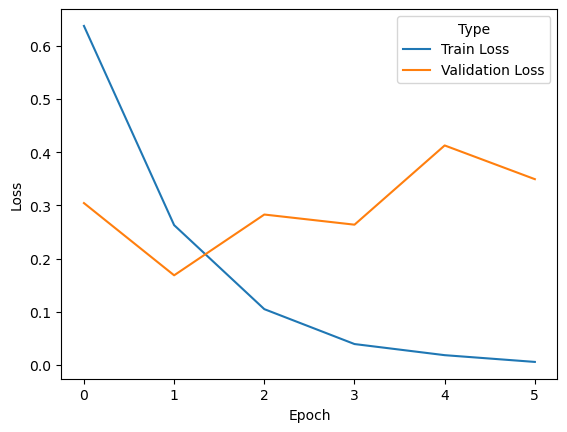

In [50]:
train_epoch_idx = range(len(train_loss_history))
val_epoch_idx = range(len(val_loss_history))

losses_df = pd.DataFrame(columns=["Epoch", "Loss", "Type"], data={"Epoch": [_i for _i in train_epoch_idx] + [_i for _i in val_epoch_idx], "Loss": train_loss_history + val_loss_history, "Type": ["Train Loss"]*len(train_epoch_idx) + ["Validation Loss"]*len(val_epoch_idx)})
sns.lineplot(losses_df, x="Epoch" , y="Loss", hue="Type")

<AxesSubplot:xlabel='Epoch', ylabel='F1'>

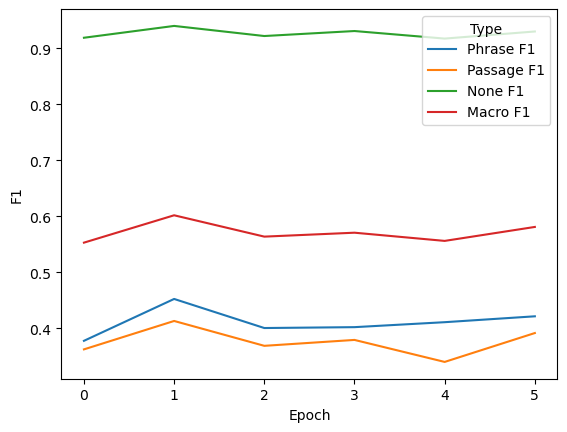

In [51]:
train_epoch_idx = range(len(phrase_f1))

f1_df = pd.DataFrame(columns=["Epoch", "F1", "Type"], data={"Epoch": [_i for _i in train_epoch_idx] + [_i for _i in train_epoch_idx] + [_i for _i in train_epoch_idx] + [_i for _i in train_epoch_idx], "F1": phrase_f1 + passage_f1 + none_f1 + macro_f1, "Type": ["Phrase F1"]*len(train_epoch_idx) + ["Passage F1"]*len(train_epoch_idx) + ["None F1"]*len(train_epoch_idx) + ["Macro F1"]*len(train_epoch_idx)})
sns.lineplot(f1_df, x="Epoch" , y="F1", hue="Type")

In [42]:
# evaluate best model

running_loss = 0.
val_running_loss_history = []

batch_wise_target_paragraph_ids = []
batch_wise_uuids = []
batch_wise_logits = []
batch_wise_labels = []
batch_wise_predictions = []

for _idx, batch in enumerate(eval_dataloader):

    batch_wise_uuids.append(batch['uuid'])
    batch_wise_target_paragraph_ids.append(batch['targetParagraphId'])
    batch = {k: v.to(device) for k, v in batch.items() if k not in ['uuid', 'targetParagraphId']}

    with torch.no_grad():

        outputs = model(**batch)

        loss = outputs.loss
        loss_value = loss.item()
        logits = outputs.logits

        running_loss += (loss_value - running_loss) / (_idx + 1)
        val_running_loss_history.append(running_loss)

        predictions = torch.argmax(logits, dim=-1)

        batch_wise_labels.append(batch['labels'].tolist())
        batch_wise_predictions.append(predictions.tolist())
        batch_wise_logits.append(logits.tolist())

print('Mean Val Loss: {}'.format(np.mean(val_running_loss_history)))

all_uuids = list(chain.from_iterable(batch_wise_uuids))
all_target_paragraph_ids = list(chain.from_iterable(batch_wise_target_paragraph_ids))
all_labels = list(chain.from_iterable(batch_wise_labels))
all_predictions = list(chain.from_iterable(batch_wise_predictions))
all_logits = list(chain.from_iterable(batch_wise_logits))

print('Val Metrics')
print(classification_report(all_labels, all_predictions, target_names=['none', 'phrase', 'passage']))

Mean Val Loss: 0.34928376471192835
Val Metrics
              precision    recall  f1-score   support

        none       0.93      0.93      0.93     20972
      phrase       0.42      0.43      0.42      1362
     passage       0.40      0.38      0.39      1456

    accuracy                           0.87     23790
   macro avg       0.58      0.58      0.58     23790
weighted avg       0.87      0.87      0.87     23790



In [43]:
# group results by uuid

grouped_by_uuid = {}
for _uuid, _target_paragraph_id, _label, _logits, _prediction in zip(all_uuids, all_target_paragraph_ids, all_labels, all_logits, all_predictions):
    if _uuid not in grouped_by_uuid:
        grouped_by_uuid[_uuid] = [{
            'target_paragraph_id': _target_paragraph_id.tolist(),
            'label': _label,
            'logits': _logits,
            'max_logit_index': _prediction
        }]
    else:
        grouped_by_uuid[_uuid].append({
            'target_paragraph_id': _target_paragraph_id.tolist(),
            'label': _label,
            'logits': _logits,
            'max_logit_index': _prediction
        })

In [44]:
# remove any duplicate occurances

unique_grouped_by_uuid = {_uuid: [] for _uuid in grouped_by_uuid.keys()}
target_paragraph_ids_grouped_by_uuid = {_uuid: [] for _uuid in grouped_by_uuid.keys()}
for _uuid in grouped_by_uuid.keys():
    for _data in grouped_by_uuid[_uuid]:
        if _data['target_paragraph_id'] not in target_paragraph_ids_grouped_by_uuid[_uuid]:
            target_paragraph_ids_grouped_by_uuid[_uuid].append(_data['target_paragraph_id'])
            unique_grouped_by_uuid[_uuid].append(_data)
            

In [45]:
# sort grouped results so that we can get the best result first
# we do this for easily access top k paragraphs as per our classification model

sorted_results_grouped_by_uuid = {}
for _uuid in unique_grouped_by_uuid.keys():
    spoilers_sorted = sorted([_x for _idx, _x in enumerate(unique_grouped_by_uuid[_uuid]) if _x['max_logit_index'] in [1, 2]], key=lambda _x: _x['logits'][_x['max_logit_index']], reverse=True)
    non_spoilers_sorted = sorted([_x for _idx, _x in enumerate(unique_grouped_by_uuid[_uuid]) if _x['max_logit_index'] in [0]], key=lambda _x: _x['logits'][_x['max_logit_index']], reverse=False)
    
    sorted_results_grouped_by_uuid[_uuid] = spoilers_sorted + non_spoilers_sorted

In [46]:
# function to get top-k metrics

def evaluate_topk(sorted_results_grouped_by_uuid, k):
    P = []
    R = []
    F1 = []
    N = []
    P_D = []
    R_D = []
    _avg_precision = 0.
    _avg_recall = 0.
    _avg_f1 = 0.
    precision = 0.
    recall = 0.
    f1 = 0.
    for _uuid, _data in sorted_results_grouped_by_uuid.items():
        _true_spoiler_positions = [_idx for _idx, _x in enumerate(_data) if _x['label'] in [1, 2]]
        _intersection = len([_pos for _pos in _true_spoiler_positions if _pos <= k])
        _p_denominator = min(k, len(_data))
        _r_denominator = len(_true_spoiler_positions)
        _p = _intersection/_p_denominator if _p_denominator != 0.0 else 0.0
        _r = _intersection/_r_denominator if _r_denominator != 0.0 else 0.0
        
        P.append(_p)
        R.append(_r)
        N.append(_intersection)
        P_D.append(_p_denominator)
        R_D.append(_r_denominator)
    _avg_precision = np.mean(P)
    _avg_recall = np.mean(R)
    _avg_f1 = (2*_avg_precision*_avg_recall)/(_avg_precision+_avg_recall)
    
    precision = float(sum(N))/sum(P_D)
    recall = float(sum(N))/sum(R_D)
    f1 = (2*precision*recall)/(precision+recall)
    
    return _avg_precision, _avg_recall, _avg_f1, precision, recall, f1
    

<AxesSubplot:xlabel='K', ylabel='Score'>

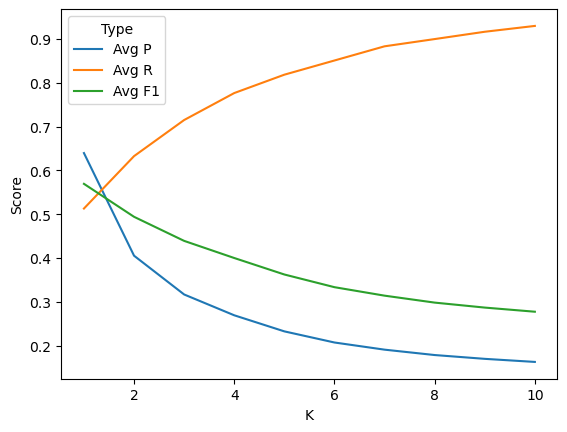

In [52]:
# get the results for topk from 1 - 11

top_k_index = list(range(1, 11))
avg_p, avg_r, avg_f1, _, _, _= zip(*[evaluate_topk(sorted_results_grouped_by_uuid, _k) for _k in top_k_index] )

losses_df = pd.DataFrame(columns=["K", "Score", "Type"], data={"K": top_k_index + top_k_index + top_k_index, "Score": avg_p + avg_r + avg_f1, "Type": ["Avg P"]*len(top_k_index) + ["Avg R"]*len(top_k_index) + ["Avg F1"]*len(top_k_index)})
sns.lineplot(losses_df, x="K" , y="Score", hue="Type")


In [81]:
# as you see recall approaches 1 as the k approaches 10
# we try out k=4 and k=10 during evaluation of Q&A

In [82]:
# data preparation for QA

In [72]:
# get sorted data, sorted by scores for question answering
# this will help us do QA with just topk data from classification and not all data

def get_sorted_val_data_sorted_on_topk_scores(val_data,
                                              sorted_classification_results_grouped_by_uuid,
                                              topk):
    
    group_data_by_uuid_and_target_paragraph_id = {}
    for _data in val_data:
        _uuid = _data['uuid']
        _target_paragraph_id = _data['targetParagraphId']

        if _uuid not in group_data_by_uuid_and_target_paragraph_id:
            group_data_by_uuid_and_target_paragraph_id[_uuid] = {}

        if _target_paragraph_id not in group_data_by_uuid_and_target_paragraph_id[_uuid]:
            group_data_by_uuid_and_target_paragraph_id[_uuid][_target_paragraph_id] = _data

    sorted_data_by_uuid_and_target_paragraph_id = []
    
    for _uuid in sorted_classification_results_grouped_by_uuid.keys():
        for _idx, _ in zip(range(len(sorted_classification_results_grouped_by_uuid[_uuid])), range(topk)):
            _target_paragraph_id = sorted_classification_results_grouped_by_uuid[_uuid][_idx]['target_paragraph_id']
            sorted_data_by_uuid_and_target_paragraph_id.append(group_data_by_uuid_and_target_paragraph_id[_uuid][_target_paragraph_id])
    
    return sorted_data_by_uuid_and_target_paragraph_id
    

In [80]:
# val data top 4
sorted_flattened_val_data_top_4 = get_sorted_val_data_sorted_on_topk_scores(
    val_data=flattened_val_data,
    sorted_classification_results_grouped_by_uuid=sorted_results_grouped_by_uuid,
    topk=4
)
json.dump(sorted_flattened_val_data_top_4, open(val_qa_data_bert_top_4_file_path, 'w'), indent=4)

# val data top 10
sorted_flattened_val_data_top_10 = get_sorted_val_data_sorted_on_topk_scores(
    val_data=flattened_val_data,
    sorted_classification_results_grouped_by_uuid=sorted_results_grouped_by_uuid,
    topk=10
)
json.dump(sorted_flattened_val_data_top_10, open(val_qa_data_bert_top_10_file_path, 'w'), indent=4)


In [84]:
# get oracle data

def get_oracle_val_data(val_data,):
    
    group_data_by_uuid_and_target_paragraph_id = {}
    oracle_data = []
    for _data in val_data:
        _spoiler_type = _data['spoilerType']
        if _spoiler_type:
            oracle_data.append(_data)
    
    return oracle_data


In [95]:
# val data oracle

flattened_val_data_oracle = get_oracle_val_data(
    val_data=flattened_val_data)
json.dump(flattened_val_data_oracle, open(val_qa_data_oracle_file_path, 'w'), indent=4)


In [96]:
# get all data for both train and val

def get_all_data(data):
    unique_data = []
    unique_grouped_by_uuid = {}
    for _data in data:
        _uuid = _data['uuid']
        _target_paragraph_id = _data['targetParagraphId']

        if _uuid not in unique_grouped_by_uuid:
            unique_grouped_by_uuid[_uuid] = []
        
        if _target_paragraph_id not in unique_grouped_by_uuid[_uuid]:
            unique_grouped_by_uuid[_uuid].append(_target_paragraph_id)
            unique_data.append(_data)

    
    return unique_data

In [99]:
# all train data
flattened_train_data_all = get_all_data(data=flattened_train_data)
json.dump(flattened_train_data_all, open(train_qa_data_all_file_path, 'w'), indent=4)

# all val data
flattened_val_data_all = get_all_data(data=flattened_val_data)
json.dump(flattened_val_data_all, open(val_qa_data_all_file_path, 'w'), indent=4)


In [ ]:
pass